# Gaussian Processes for Machine Learning

Consider the Gaussian process given by:

$f \sim \mathcal{GP}(m,k)$,  where $m(x)=\frac{1}{4}x^2$, and $k(x, x')=\exp(-\frac{1}{2}(x-x')^2)$

In order to understand this process we can draw samples from the function $f$. In order to work only with finite quantities, we request only the value of f at a distinct finite number n of locations. How do we generate such samples? Given the $x$-values we can evaluate the vector of means and a covariance matrix using Eq., which defines a regular Gaussian distribution:

$\mu_i = m(x_i) = \frac{1}{4}x_i^2$, $i=1,2,...,n$ and

$\Sigma_{ij} = k(x_i, x_j)=\exp(-\frac{1}{2}(x_i-x_j)^2)$, $i,j=1,2,...,n$

where to clarify the distinction between process and distribution we use $m$ and $k$ for the former and $\mu$ and $\Sigma$ for the latter. We can now generate a random vector from this distribution. This vector will have as coordinates the function values $f(x)$ for the corresponding $x$'s:

$f \sim \mathcal{N}(\mu, \Sigma)$

We could now plot the values of $f$ as a function of $x$, see Figure. How can we do this in practice?

In [3]:
%matplotlib inline

from __future__ import division
import numpy as np
import seaborn as sns  # pretty graphics in matplotlib

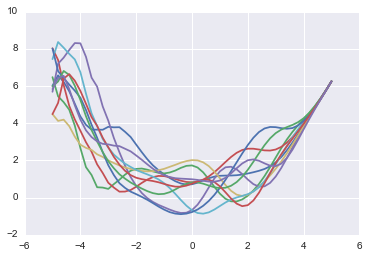

In [4]:
xs = np.array([np.arange(-5, 5.1, 0.2)]).T
ns = xs.shape[0]
keps = 1e-9
m = lambda x: 0.25 * x**2
# Matlab: repmat(a, m, n)
# Python: tile(a, (m, n))
K = lambda p, q: np.exp(-0.5 * (np.tile(p.T, q.shape) - np.tile(q, p.T.shape))**2)

for i in range(10):
    fs = m(xs) + np.dot( np.linalg.cholesky(K(xs, xs) + keps*np.eye(ns)).T, np.random.standard_normal((ns, 1)) )
    plot(xs, fs)

## Posterior Gaussian Process

One of the primary goals computing the posterior is that it can be used to make predictions for unseen test cases. Let $f$ be the known function values of the training cases, and let $f_∗$ be a set of function values corresponding to the test set inputs, $X_∗$ . Again, we write out the joint distribution of everything we are interested in:

$\begin{bmatrix}
f \\
f_*
\end{bmatrix} \sim \mathcal{N} \left( \begin{bmatrix}
\mu \\
\mu_*
\end{bmatrix}, \begin{bmatrix}
\Sigma & \Sigma_* \\
\Sigma_*^T & \Sigma_{**}
\end{bmatrix} \right)$

where we've introduced the following shorthand: $\mu = m(x_i), i = 1,..., n$ for the training means and analogously for the test means $\mu_*$; for the covariance we use $\Sigma$ for training set covariances, $\Sigma_*$ for training-test set covariances and $\Sigma_{**}$ for test set covariances. Since we know the values for the training set $f$ we are interested in the conditional distribution of f ∗ given f which is expressed as:

$f_∗ | f \sim \mathcal{N} (\mu_∗ + \Sigma_∗^T \Sigma^{−1} (f − \mu), \Sigma_{**} − \Sigma_∗ \Sigma^{−1} \Sigma_∗$

This is the posterior distribution for a specific set of test cases. It is easy to verify (by inspection) that the corresponding posterior process is:

$f|\mathcal{D} \sim \mathcal{GP}(m_\mathcal{D}, k_\mathcal{D})$  where,

   $m_\mathcal{D} (x) = m(x) + \Sigma(X, x)^T \Sigma^{−1} (f - m)$
   
   $k_mathcal{D} (x, x') = k(x, x') - \Sigma(X, x)^T \Sigma^{-1} \Sigma(X, x')$
   
where $\Sigma(X, x)$ is a vector of covariances between every training case and $x$. These are the central equations for Gaussian process predictions. Let's examine these equations for the posterior mean and covariance. Notice that the posterior variance $k_\mathcal{D} (x, x)$ is equal to the prior variance $k(x, x)$ minus a positive term, which depends on the training inputs; thus the posterior variance is always smaller than the prior variance, since the data has given us some additional information.

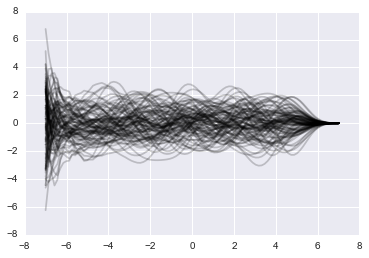

In [5]:
ns = 100
xs = np.atleast_2d([np.linspace(-7, 7, ns)]).T
keps = 1e-9
m = lambda x: 0.25 * x**2
# Matlab: repmat(a, m, n)
# Python: tile(a, (m, n))
K = lambda p, q: np.exp(-0.5 * (np.tile(p.T, q.shape) - np.tile(q, p.T.shape))**2)

for i in range(100):
    #fs = m(xs) + np.dot( np.linalg.cholesky(K(xs, xs) + keps*np.eye(ns)).T, np.random.standard_normal((ns, 1)) )
    fs = np.dot( np.linalg.cholesky(K(xs, xs) + keps*np.eye(ns)).T, np.random.standard_normal((ns, 1)) )
    plot(xs, fs, color=(0.0, 0.0, 0.0, 0.2))

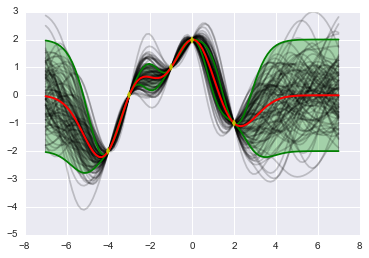

In [6]:
# Observations
x = np.atleast_2d(np.array([-4, -3, -1, 0, 2])).T
y = np.atleast_2d(np.array([-2, 0, 1, 2, -1])).T

# Covariance matrices
kxx = K(x, x)  # training
kxxs = K(x, xs)
kxsxs = K(xs, xs)  # predictions

# Get values
r = kxx.shape[0]
fs = np.dot(kxxs, np.dot( np.linalg.solve(kxx, np.eye(r)), y))
cov = kxsxs - np.dot(kxxs, np.dot( np.linalg.solve(kxx, np.eye(r)), kxxs.T))
val = np.zeros((ns, ns))
for i in range(ns):
    val[:, i] = np.random.multivariate_normal(fs.ravel(), cov)

# Random samples
plot(xs, val, color=(0.0, 0.0, 0.0, 0.2))

# Covariance limits at 2sigma
ytop = fs.ravel() + 2.0 * np.diag(cov)
ybot = fs.ravel() - 2.0 * np.diag(cov)
fill_between(xs.ravel(), ybot, ytop, where=ytop>=ybot, facecolor=(0.0, 0.6, 0.0, 0.3), interpolate=True)
plot(xs, fs.ravel() + 2.0 * np.diag(cov), 'g')
plot(xs, fs.ravel() - 2.0 * np.diag(cov), 'g')

# Function
plot(xs, fs, 'r', linewidth=2)

# Training points (no uncertainty)
plot(x, y, 'dy', ms=5);

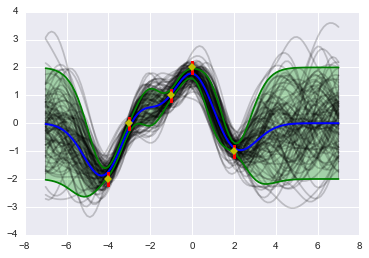

In [7]:
# 3. Now assume that each of the observed data points have some
# normally-distributed noise.
sigman = 0.1

r = kxx.shape[0]
fs = np.dot(kxxs, np.dot( np.linalg.solve(kxx + sigman * np.eye(r), np.eye(r)), y))
cov = kxsxs - np.dot(kxxs, np.dot( np.linalg.solve(kxx + sigman * np.eye(r), np.eye(r)), kxxs.T))

# Compute random samples
val = np.zeros((ns, ns))
for i in range(ns):
    val[:, i] = np.random.multivariate_normal(fs.ravel(), cov)

# Random samples
plot(xs, val, color=(0.0, 0.0, 0.0, 0.2))

# Covariance limits at 2sigma
ytop = fs.ravel() + 2.0 * np.diag(cov)
ybot = fs.ravel() - 2.0 * np.diag(cov)
fill_between(xs.ravel(), ybot, ytop, where=ytop>=ybot, facecolor=(0.0, 0.6, 0.0, 0.3), interpolate=True)
plot(xs, fs.ravel() + 2.0 * np.diag(cov), 'g')
plot(xs, fs.ravel() - 2.0 * np.diag(cov), 'g')

# Predicted function
plot(xs, fs, 'b', linewidth=2)

# Training points with uncertainty
x = x.ravel()
y = y.ravel()
yerr = 2 * sigman * np.ones(x.shape)
for i in range(len(x)):
    plot([x[i], x[i]], [y[i]+yerr, y[i]-yerr], 'r', linewidth=3)
plot(x, y, 'y', ls='', marker='D', ms=5);